# Author: Abdullah Moosa 03/11/2024

### **In this notebook the data will be applied on both the Categorical dataset and the Binary one(Dataset 1 and 2)**

## Importing Libraries

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


This notebook uses cuda for gpu acceleration , because it speeds up training time and this can be accessed via the framework Pytorch, which is a popular framework for ML application.

# **Application on Dataset 1**

## Dataset loading and set up 

In [52]:
# load and preprocess data
def load_and_preprocess_data(file_path): # set test_size to 20%
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values #drop the target coloumn LUNG_CANCER
    y = df['LUNG_CANCER'].values

    # Check if labels are 1 and 2, and map to 0 and 1 if needed (for og_)
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

In [53]:
# Define a configurable MLP architecture with PyTorch
class ConfigurableMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation):
        super(ConfigurableMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for neurons in hidden_layers:
            layers.append(nn.Linear(prev_dim, neurons))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_dim = neurons
        layers.append(nn.Linear(prev_dim, 1))  # Output layer
        layers.append(nn.Sigmoid())  # Binary classification
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [54]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            verbose (bool): If True, prints a message for each improvement.
            delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

In [55]:
# List of dataset paths to evaluate
dataset_paths = [
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_b.csv'
]

# Define hyperparameter grid including 'dataset_path'
param_grid = {
    'dataset_path': dataset_paths,  # Added dataset paths
    'hidden_layers': [
        [15], [15, 15], [15, 15, 15], [15, 15, 15, 15], [15, 15, 15, 15, 15]
    ],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'epochs': [10, 25, 50],  # Updated epoch options
}

# Fixed parameters
batch_size = 32  # Not used in current implementation but kept for reference

# Perform grid search
results = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate total number of configurations for progress tracking
total_configs = len(param_grid['dataset_path']) * len(param_grid['hidden_layers']) * len(param_grid['learning_rate']) * \
               len(param_grid['activation']) * len(param_grid['optimizer']) * len(param_grid['epochs'])
current_config = 1

In [56]:
for dataset_path in param_grid['dataset_path']:
    for hidden_layers in param_grid['hidden_layers']:
        for learning_rate in param_grid['learning_rate']:
            for activation in param_grid['activation']:
                for optimizer_name in param_grid['optimizer']:
                    for epoch in param_grid['epochs']:
                        f1_scores = []
                        dataset_name = dataset_path.split('/')[-1]
                        print(f"Testing config {current_config}/{total_configs}: "
                              f"Dataset={dataset_name}, Layers={hidden_layers}, LR={learning_rate}, "
                              f"Activation={activation}, Optimizer={optimizer_name}, Epochs={epoch}")
                        
                        # Load and preprocess data for the current dataset
                        X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)
                        
                        # Perform Stratified K-Fold Cross-Validation
                        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train.cpu().numpy(), y_train.cpu().numpy().ravel()), 1):
                            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                            # Build the model
                            model = ConfigurableMLP(input_dim=X_train.shape[1], hidden_layers=hidden_layers, activation=activation).to(device)
                            
                            # Define optimizer
                            if optimizer_name == 'adam':
                                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'sgd':
                                optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'rmsprop':
                                optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                            
                            # Define loss function
                            criterion = nn.BCELoss()

                            # Initialize Early Stopping
                            early_stopping = EarlyStopping(patience=10, verbose=False)

                            # Training loop with Early Stopping
                            model.train()
                            for epoch_num in range(1, epoch + 1):
                                optimizer.zero_grad()
                                y_pred = model(X_train_fold)
                                loss = criterion(y_pred, y_train_fold)
                                loss.backward()
                                optimizer.step()

                                # Evaluate on validation fold
                                model.eval()
                                with torch.no_grad():
                                    y_val_pred_prob = model(X_val_fold)
                                    val_loss = criterion(y_val_pred_prob, y_val_fold).item()
                                
                                # Call Early Stopping
                                early_stopping(val_loss, model)
                                
                                if early_stopping.early_stop:
                                    if early_stopping.verbose:
                                        print(f"Early stopping at epoch {epoch_num}")
                                    break
                                
                                model.train()
                            
                            # Load the best model state
                            if early_stopping.best_model_state is not None:
                                model.load_state_dict(early_stopping.best_model_state)
                            
                            # Evaluate the model
                            model.eval()
                            with torch.no_grad():
                                y_val_pred = (model(X_val_fold) > 0.5).cpu().numpy().astype(int)
                            f1 = f1_score(y_val_fold.cpu().numpy(), y_val_pred, zero_division=0)
                            f1_scores.append(f1)

                        # Record the average F1-score for this configuration
                        avg_f1 = np.mean(f1_scores)
                        results.append({
                            'dataset': dataset_name,
                            'hidden_layers': hidden_layers,
                            'learning_rate': learning_rate,
                            'activation': activation,
                            'optimizer': optimizer_name,
                            'epochs': epoch,
                            'avg_f1_score': avg_f1
                        })
                        print(f"Average F1-Score: {avg_f1}\n")
                        current_config += 1

Testing config 1/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=10
Average F1-Score: 0.6380273857215798

Testing config 2/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=25
Average F1-Score: 0.564034235334487

Testing config 3/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=adam, Epochs=50
Average F1-Score: 0.7132107420452785

Testing config 4/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=10
Average F1-Score: 0.2802547586868269

Testing config 5/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=25
Average F1-Score: 0.4333010752688171

Testing config 6/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=sgd, Epochs=50
Average F1-Score: 0.449583061105987

Testing config 7/810: Dataset=1_ef_b.csv, Layers=[15], LR=0.001, Activation=relu, Optimizer=rmsprop, Epochs=10
Average F1-Score: 

In [57]:
# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by F1-score to identify the best configuration
best_config = results_df.sort_values(by='avg_f1_score', ascending=False).iloc[0]
print("\nBest Configuration:")
print(best_config)


Best Configuration:
dataset          1_og_b.csv
hidden_layers      [15, 15]
learning_rate           0.1
activation             relu
optimizer              adam
epochs                   10
avg_f1_score       0.950952
Name: 630, dtype: object


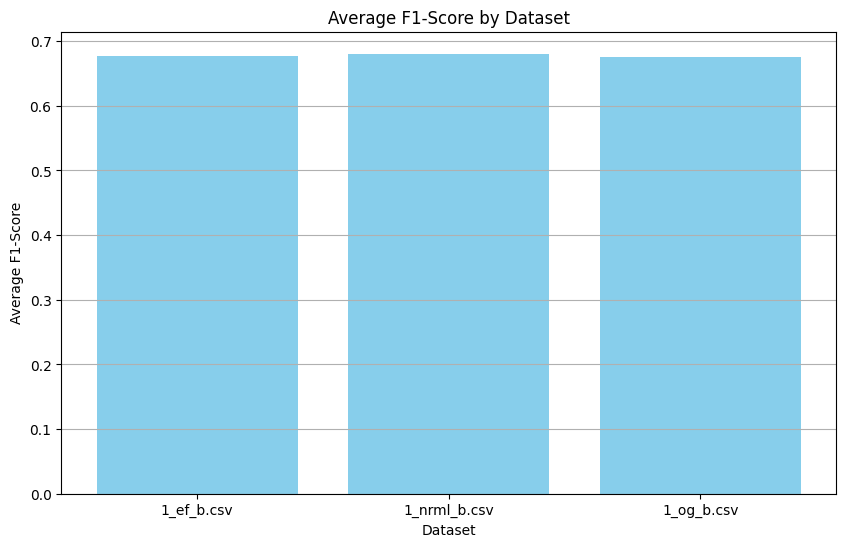


Average F1-Score by Dataset:
     dataset  avg_f1_score
  1_ef_b.csv      0.677517
1_nrml_b.csv      0.680562
  1_og_b.csv      0.675112


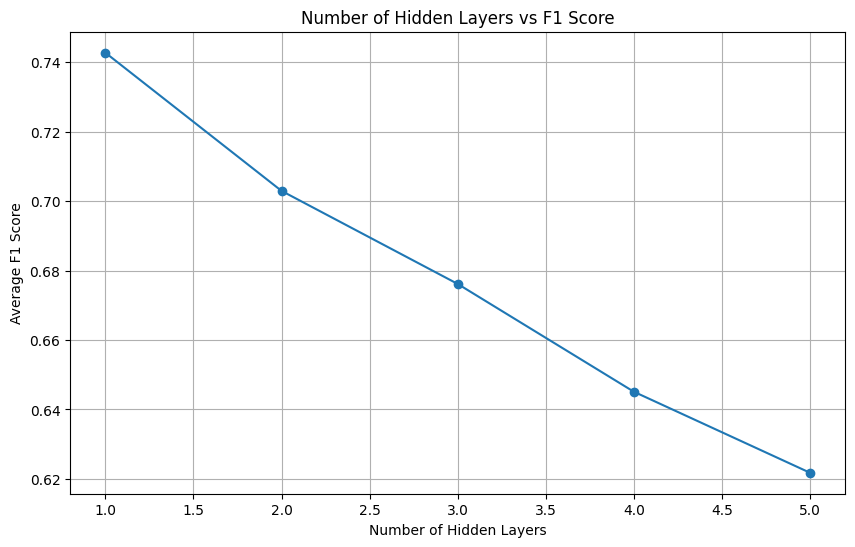


Average F1-Score by Number of Hidden Layers:
 num_hidden_layers  avg_f1_score
                 1      0.742676
                 2      0.702915
                 3      0.676141
                 4      0.645119
                 5      0.621801


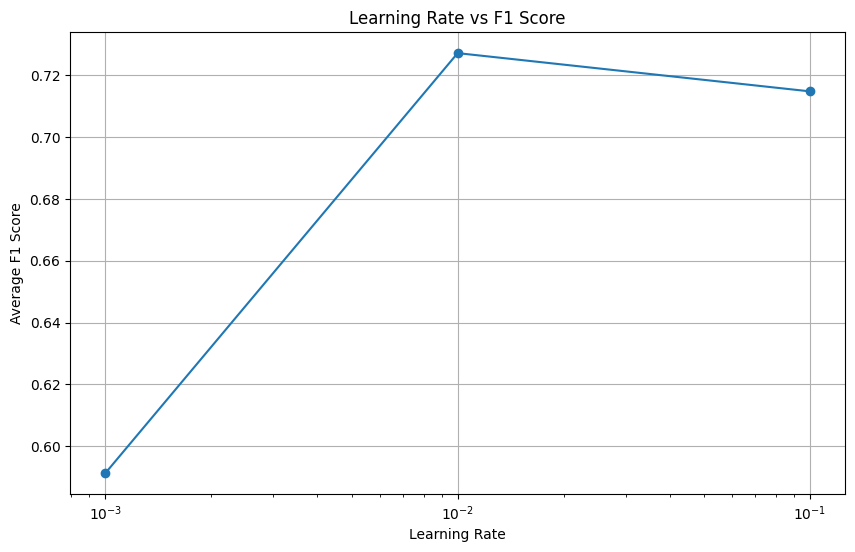


Average F1-Score by Learning Rate:
 learning_rate  avg_f1_score
         0.001      0.591281
         0.010      0.727140
         0.100      0.714770


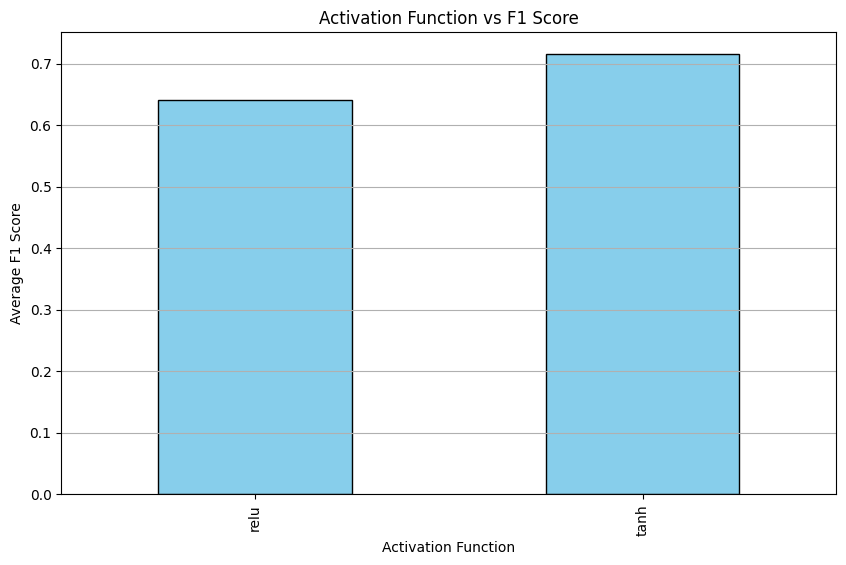


Average F1-Score by Activation Function:
activation  avg_f1_score
      relu      0.640135
      tanh      0.715326


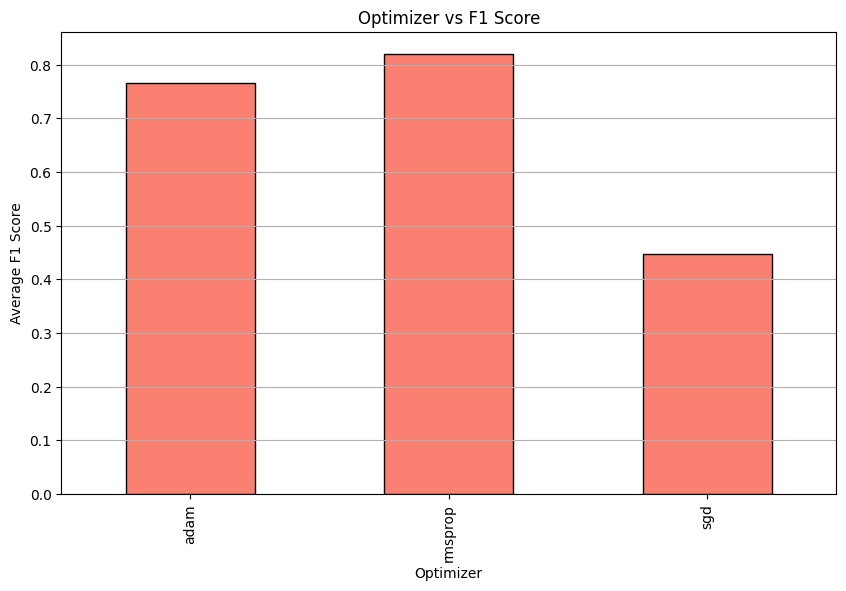


Average F1-Score by Optimizer:
optimizer  avg_f1_score
     adam      0.765509
  rmsprop      0.820439
      sgd      0.447243


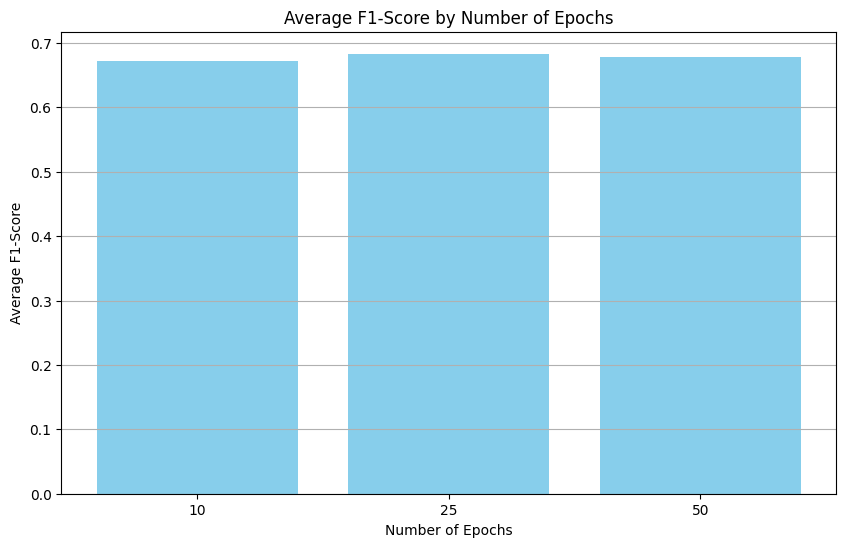


Average F1-Score by Number of Epochs:
 epochs  avg_f1_score
     10      0.671317
     25      0.683188
     50      0.678685


In [58]:
# Assuming `results_df` is your DataFrame containing the results
# Ensure results_df is already defined and populated with your hyperparameter search results



# Analyze the effect of datasets
dataset_analysis = results_df.groupby('dataset')['avg_f1_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(dataset_analysis['dataset'], dataset_analysis['avg_f1_score'], color='skyblue')

plt.title("Average F1-Score by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')

plt.show()


print("\nAverage F1-Score by Dataset:")
print(dataset_analysis.to_string(index=False))


# Calculate the number of hidden layers for each configuration
results_df['num_hidden_layers'] = results_df['hidden_layers'].apply(len)

# Group by the number of hidden layers and compute the mean F1 score
hidden_layer_f1 = results_df.groupby('num_hidden_layers')['avg_f1_score'].mean()

# Plot: Number of Hidden Layers vs F1 Score
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_f1.index, hidden_layer_f1.values, marker='o', linestyle='-')
plt.title('Number of Hidden Layers vs F1 Score')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.show()


print("\nAverage F1-Score by Number of Hidden Layers:")
print(hidden_layer_f1.reset_index().to_string(index=False))

# Plot: Learning Rate vs F1 Score
learning_rate_f1 = results_df.groupby('learning_rate')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_f1.index, learning_rate_f1.values, marker='o', linestyle='-')
plt.title('Learning Rate vs F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Average F1 Score')
plt.xscale('log')  # Log scale for learning rate
plt.grid(True)
plt.show()

print("\nAverage F1-Score by Learning Rate:")
print(learning_rate_f1.reset_index().to_string(index=False))


# Plot: Activation Function vs F1 Score
activation_f1 = results_df.groupby('activation')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
activation_f1.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Activation Function vs F1 Score')
plt.xlabel('Activation Function')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()


print("\nAverage F1-Score by Activation Function:")
print(activation_f1.reset_index().to_string(index=False))

# Plot: Optimizer vs F1 Score
optimizer_f1 = results_df.groupby('optimizer')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
optimizer_f1.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Optimizer vs F1 Score')
plt.xlabel('Optimizer')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Optimizer:")
print(optimizer_f1.reset_index().to_string(index=False))


# Analyze the effect of epochs
epochs_analysis = results_df.groupby('epochs')['avg_f1_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(epochs_analysis['epochs'].astype(str), epochs_analysis['avg_f1_score'], color='skyblue')
plt.title("Average F1-Score by Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Number of Epochs:")
print(epochs_analysis.to_string(index=False))

In [59]:
# Sort by F1-score to identify the best configurations
top_10_configs = results_df.sort_values(by='avg_f1_score', ascending=False).head(10)
print("\nTop 10 Configurations:")
print(top_10_configs)



Top 10 Configurations:
          dataset hidden_layers  learning_rate activation optimizer  epochs  \
630    1_og_b.csv      [15, 15]           0.10       relu      adam      10   
631    1_og_b.csv      [15, 15]           0.10       relu      adam      25   
362  1_nrml_b.csv      [15, 15]           0.10       relu      adam      50   
360  1_nrml_b.csv      [15, 15]           0.10       relu      adam      10   
350  1_nrml_b.csv      [15, 15]           0.01       relu   rmsprop      50   
361  1_nrml_b.csv      [15, 15]           0.10       relu      adam      25   
618    1_og_b.csv      [15, 15]           0.01       relu   rmsprop      10   
593    1_og_b.csv          [15]           0.10       tanh   rmsprop      50   
673    1_og_b.csv  [15, 15, 15]           0.01       relu   rmsprop      25   
592    1_og_b.csv          [15]           0.10       tanh   rmsprop      25   

     avg_f1_score  num_hidden_layers  
630      0.950952                  2  
631      0.948626           

In [60]:
# Save the entire results DataFrame to a CSV file
results_df.to_csv('hyperparameter_search_results.csv', index=False)
print("\nAll configurations have been saved to 'dataset1_hyperparameter_results.csv'.")


All configurations have been saved to 'dataset1_hyperparameter_results.csv'.



=== Top 10 Configurations Based on Average F1-Score ===


,dataset,hidden_layers,learning_rate,activation,optimizer,epochs,avg_f1_score,num_hidden_layers
0,1_og_b.csv,"(15, 15)",0.10,relu,adam,10,0.950952,2
1,1_og_b.csv,"(15, 15)",0.10,relu,adam,25,0.948626,2
2,1_nrml_b.csv,"(15, 15)",0.10,relu,adam,50,0.947915,2
3,1_nrml_b.csv,"(15, 15)",0.10,relu,adam,10,0.947780,2
4,1_nrml_b.csv,"(15, 15)",0.01,relu,rmsprop,50,0.945665,2
5,1_nrml_b.csv,"(15, 15)",0.10,relu,adam,25,0.945643,2
6,1_og_b.csv,"(15, 15)",0.01,relu,rmsprop,10,0.945233,2
7,1_og_b.csv,"(15,)",0.10,tanh,rmsprop,50,0.944665,1
8,1_og_b.csv,"(15, 15, 15)",0.01,relu,rmsprop,25,0.943986,3
9,1_og_b.csv,"(15,)",0.10,tanh,rmsprop,25,0.943363,1



=== Configuration 1: Dataset=1_og_b, Layers=(15, 15), LR=0.1, Activation=relu, Optimizer=adam, Epochs=10 ===

--- Split Type: 80-20 ---

Train Metrics: {'Accuracy': 0.9722222222222222, 'TP': 205, 'FP': 1, 'TN': 215, 'FN': 11, 'Sensitivity': 0.9490740740740741, 'Specificity': 0.9953703703703703, 'Precision': 0.9951456310679612, 'Recall': 0.9490740740740741, 'F1 Score': 0.971563981042654, 'AUC': 0.9882758916323732}
Test Metrics: {'Accuracy': 0.9629629629629629, 'TP': 50, 'FP': 0, 'TN': 54, 'FN': 4, 'Sensitivity': 0.9259259259259259, 'Specificity': 1.0, 'Precision': 1.0, 'Recall': 0.9259259259259259, 'F1 Score': 0.9615384615384615, 'AUC': 0.9794238683127573}

--- Split Type: 70-30 ---

Train Metrics: {'Accuracy': 0.9656084656084656, 'TP': 176, 'FP': 0, 'TN': 189, 'FN': 13, 'Sensitivity': 0.9312169312169312, 'Specificity': 1.0, 'Precision': 1.0, 'Recall': 0.9312169312169312, 'F1 Score': 0.9643835616438355, 'AUC': 0.9803476946334089}
Test Metrics: {'Accuracy': 0.9444444444444444, 'TP': 73,

,Configuration_ID,Dataset,Hidden_Layers,Learning_Rate,Activation,Optimizer,Epochs,Split_Type,Train_Accuracy,Train_Precision,...,Train_Specificity,Train_Sensitivity,Train_AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1_Score,Test_Specificity,Test_Sensitivity,Test_AUC
0,1,1_og_b,"(15, 15)",0.10,relu,adam,10,80-20,0.972222,0.995146,...,0.995370,0.949074,0.988276,0.962963,1.000000,0.925926,0.961538,1.000000,0.925926,0.979424
1,1,1_og_b,"(15, 15)",0.10,relu,adam,10,70-30,0.965608,1.000000,...,1.000000,0.931217,0.980348,0.944444,0.986486,0.901235,0.941935,0.987654,0.901235,0.973632
2,1,1_og_b,"(15, 15)",0.10,relu,adam,10,60-40,0.962963,0.974684,...,0.975309,0.950617,0.990093,0.944444,0.952830,0.935185,0.943925,0.953704,0.935185,0.971365
3,1,1_og_b,"(15, 15)",0.10,relu,adam,10,50-50,0.966667,1.000000,...,1.000000,0.933333,0.990727,0.966667,0.992188,0.940741,0.965779,0.992593,0.940741,0.981920
4,2,1_og_b,"(15, 15)",0.10,relu,adam,25,80-20,0.979167,1.000000,...,1.000000,0.958333,0.997171,0.953704,1.000000,0.907407,0.951456,1.000000,0.907407,0.985940
5,2,1_og_b,"(15, 15)",0.10,relu,adam,25,70-30,0.973545,1.000000,...,1.000000,0.947090,0.984239,0.956790,0.986842,0.925926,0.955414,0.987654,0.925926,0.963954
6,2,1_og_b,"(15, 15)",0.10,relu,adam,25,60-40,0.987654,1.000000,...,1.000000,0.975309,0.997333,0.944444,0.989796,0.898148,0.941748,0.990741,0.898148,0.958033
7,2,1_og_b,"(15, 15)",0.10,relu,adam,25,50-50,0.970370,1.000000,...,1.000000,0.940741,0.993361,0.962963,0.992126,0.933333,0.961832,0.992593,0.933333,0.978107
8,3,1_nrml_b,"(15, 15)",0.10,relu,adam,50,80-20,0.986111,1.000000,...,1.000000,0.972222,0.999571,0.953704,1.000000,0.907407,0.951456,1.000000,0.907407,0.989026
9,3,1_nrml_b,"(15, 15)",0.10,relu,adam,50,70-30,0.978836,1.000000,...,1.000000,0.957672,0.987906,0.956790,0.986842,0.925926,0.955414,0.987654,0.925926,0.968526



All final experiment results have been saved to '/media/abood/windowsdatassd2/coursework/R5(Neural Networks)/final_experiment_results.csv'.

=== Summary Table: Accuracy by Configuration and Split Type ===


Configuration_ID Hidden_Layers Learning_Rate Activation Optimizer  \
Split_Type                                                                     
0                         1      (15, 15)          0.10       relu      adam   
1                         2      (15, 15)          0.10       relu      adam   
2                         3      (15, 15)          0.10       relu      adam   
3                         4      (15, 15)          0.10       relu      adam   
4                         5      (15, 15)          0.01       relu   rmsprop   
5                         6      (15, 15)          0.10       relu      adam   
6                         7      (15, 15)          0.01       relu   rmsprop   
7                         8         (15,)          0.10       tanh   rmsprop   
8                         9  (15, 15, 15)          0.01       relu   rmsprop   
9                        10         (15,)          0.10       tanh   rmsprop   

           Epochs Test_Accuracy                               Train_Accuracy  \
Split_Type                50-50     60-40     70-30     80-20          50-50   
0              10      0.966667  0.944444  0.944444  0.962963       0.966667   
1              25      0.962963  0.944444  0.956790  0.953704       0.970370   
2              50      0.962963  0.958333  0.956790  0.953704       0.977778   
3              10      0.948148  0.953704  0.956790  0.944444       0.959259   
4              50      0.955556  0.944444  0.944444  0.944444       0.966667   
5              25      0.933333  0.953704  0.962963  0.972222       0.944444   
6              10      0.951852  0.939815  0.944444  0.962963       0.940741   
7              50      0.962963  0.958333  0.956790  0.962963       0.974074   
8              25      0.959259  0.944444  0.950617  0.953704       0.977778   
9              25      0.959259  0.958333  0.950617  0.962963       0.974074   

                                          
Split_Type     60-40     70-30     80-20  
0           0.962963  0.965608  0.972222  
1           0.987654  0.973545  0.979167  
2           0.987654  0.978836  0.986111  
3           0.959877  0.973545  0.956019  
4           0.984568  0.973545  0.981481  
5           0.969136  0.949735  0.979167  
6           0.950617  0.965608  0.953704  
7           0.978395  0.981481  0.974537  
8           0.975309  0.973545  0.967593  
9           0.972222  0.968254  0.974537

/tmp/ipykernel_6259/2060505841.py:288: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Split_Type', y='Test_Accuracy', data=all_results_df, palette='Set3')


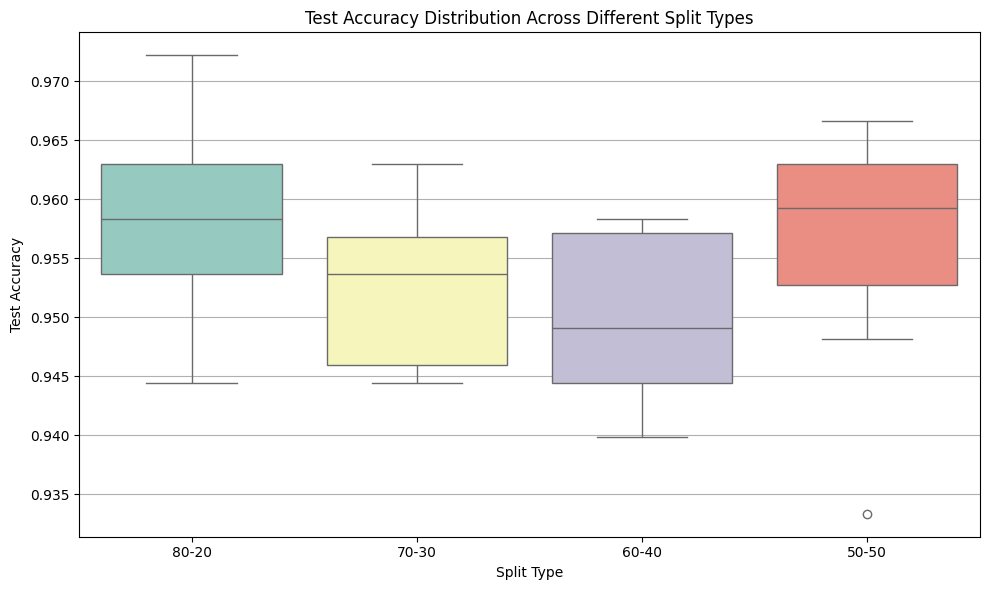

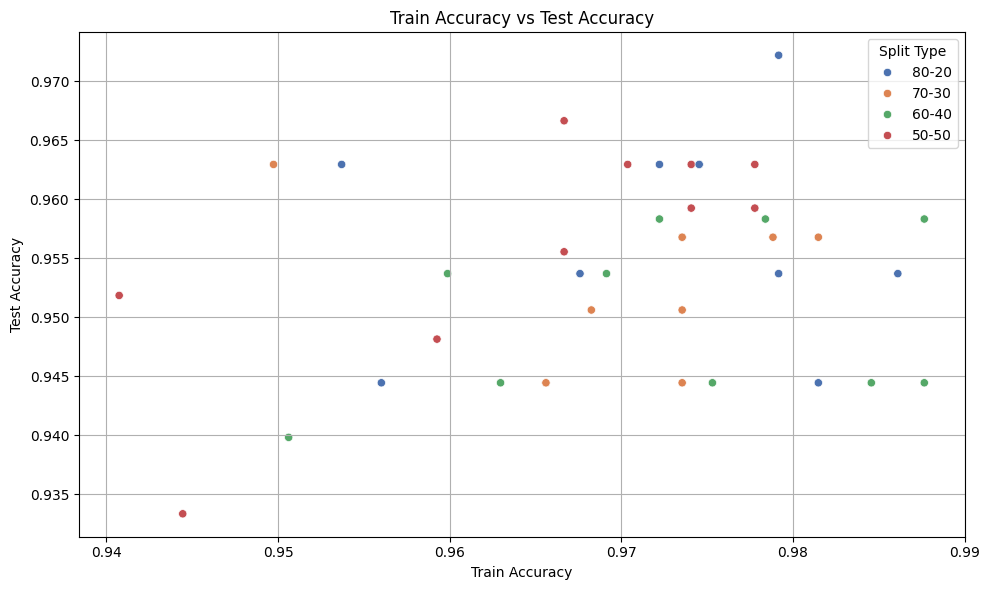

/tmp/ipykernel_6259/2060505841.py:309: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Split_Type', y='Test_F1_Score', data=all_results_df, palette='Set2')


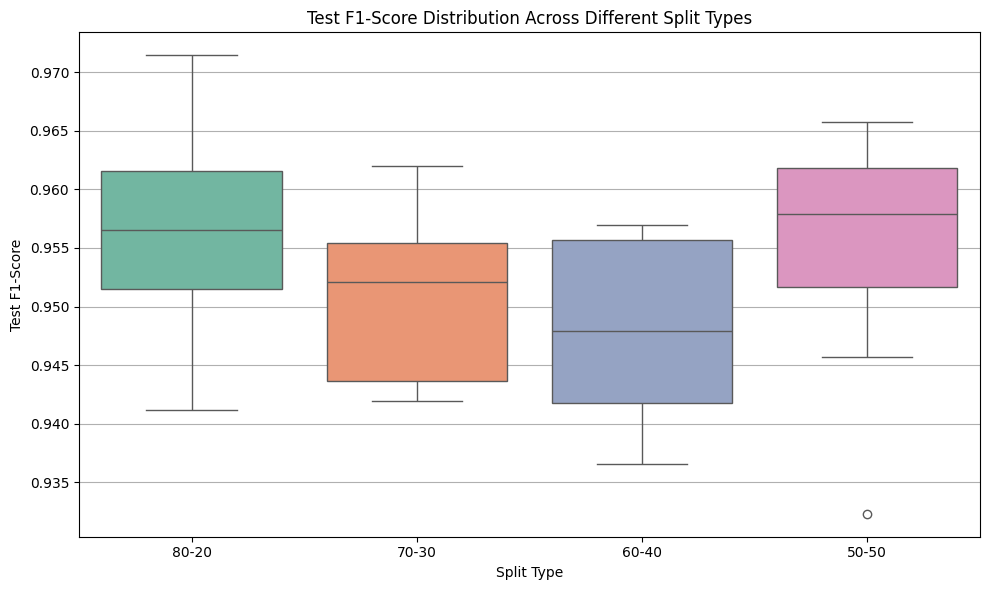


=== Detailed Metrics ===


,Configuration_ID,Dataset,Hidden_Layers,Learning_Rate,Activation,Optimizer,Epochs,Split_Type,Train_Accuracy,Train_Precision,...,Train_Specificity,Train_Sensitivity,Train_AUC,Test_Accuracy,Test_Precision,Test_Recall,Test_F1_Score,Test_Specificity,Test_Sensitivity,Test_AUC
0,1,1_og_b,"(15, 15)",0.10,relu,adam,10,80-20,0.972222,0.995146,...,0.995370,0.949074,0.988276,0.962963,1.000000,0.925926,0.961538,1.000000,0.925926,0.979424
1,1,1_og_b,"(15, 15)",0.10,relu,adam,10,70-30,0.965608,1.000000,...,1.000000,0.931217,0.980348,0.944444,0.986486,0.901235,0.941935,0.987654,0.901235,0.973632
2,1,1_og_b,"(15, 15)",0.10,relu,adam,10,60-40,0.962963,0.974684,...,0.975309,0.950617,0.990093,0.944444,0.952830,0.935185,0.943925,0.953704,0.935185,0.971365
3,1,1_og_b,"(15, 15)",0.10,relu,adam,10,50-50,0.966667,1.000000,...,1.000000,0.933333,0.990727,0.966667,0.992188,0.940741,0.965779,0.992593,0.940741,0.981920
4,2,1_og_b,"(15, 15)",0.10,relu,adam,25,80-20,0.979167,1.000000,...,1.000000,0.958333,0.997171,0.953704,1.000000,0.907407,0.951456,1.000000,0.907407,0.985940
5,2,1_og_b,"(15, 15)",0.10,relu,adam,25,70-30,0.973545,1.000000,...,1.000000,0.947090,0.984239,0.956790,0.986842,0.925926,0.955414,0.987654,0.925926,0.963954
6,2,1_og_b,"(15, 15)",0.10,relu,adam,25,60-40,0.987654,1.000000,...,1.000000,0.975309,0.997333,0.944444,0.989796,0.898148,0.941748,0.990741,0.898148,0.958033
7,2,1_og_b,"(15, 15)",0.10,relu,adam,25,50-50,0.970370,1.000000,...,1.000000,0.940741,0.993361,0.962963,0.992126,0.933333,0.961832,0.992593,0.933333,0.978107
8,3,1_nrml_b,"(15, 15)",0.10,relu,adam,50,80-20,0.986111,1.000000,...,1.000000,0.972222,0.999571,0.953704,1.000000,0.907407,0.951456,1.000000,0.907407,0.989026
9,3,1_nrml_b,"(15, 15)",0.10,relu,adam,50,70-30,0.978836,1.000000,...,1.000000,0.957672,0.987906,0.956790,0.986842,0.925926,0.955414,0.987654,0.925926,0.968526



=== Accuracy Difference (Train - Test) ===


,Configuration_ID,Split_Type,Train_Accuracy,Test_Accuracy,Accuracy_Difference
0,1,80-20,0.972222,0.962963,0.009259
1,1,70-30,0.965608,0.944444,0.021164
2,1,60-40,0.962963,0.944444,0.018519
3,1,50-50,0.966667,0.966667,0.000000
4,2,80-20,0.979167,0.953704,0.025463
5,2,70-30,0.973545,0.956790,0.016755
6,2,60-40,0.987654,0.944444,0.043210
7,2,50-50,0.970370,0.962963,0.007407
8,3,80-20,0.986111,0.953704,0.032407
9,3,70-30,0.978836,0.956790,0.022046


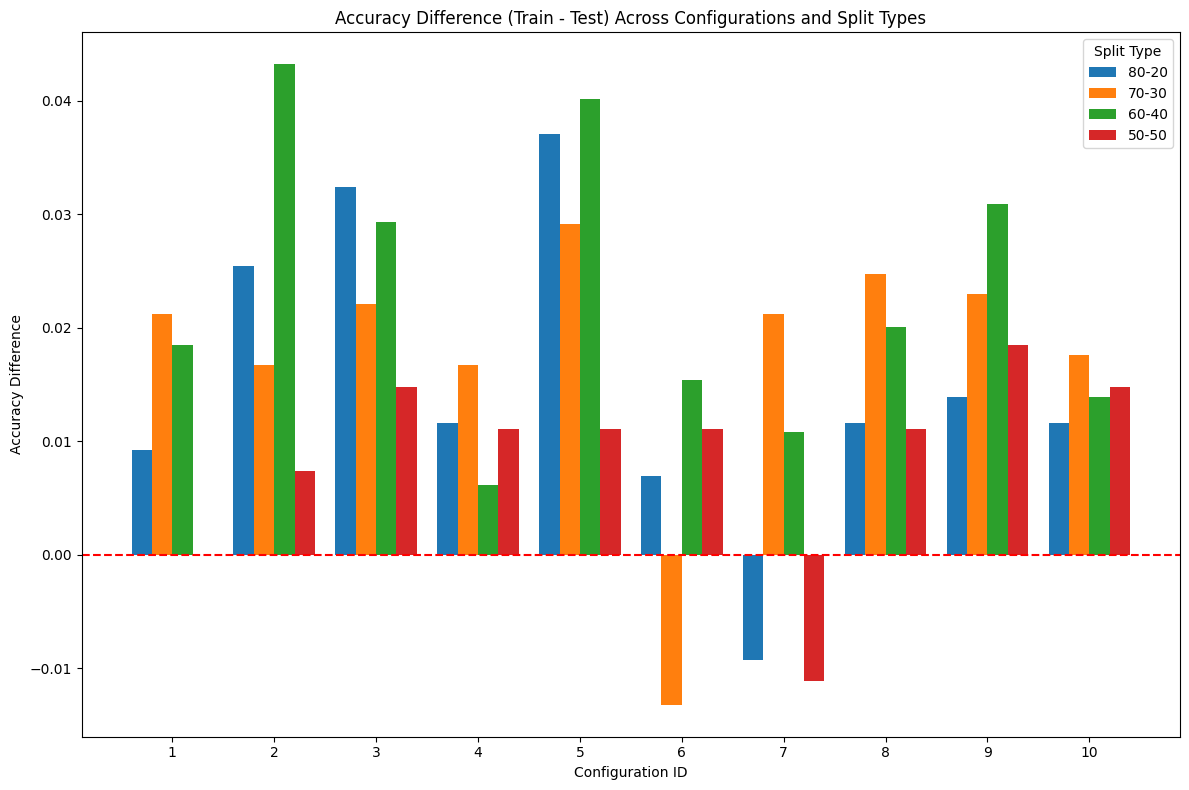

In [62]:
# %%
# Define Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
    
    def __call__(self, loss, model):
        if self.best_loss is None:
            self.best_loss = loss
            self.best_model_state = model.state_dict()
        elif loss < self.best_loss:
            self.best_loss = loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# %%
# Function to compute comprehensive metrics
def compute_metrics(y_true, y_pred, y_prob):
    """
    Compute various classification metrics.
    
    Args:
        y_true (np.array): True labels.
        y_pred (np.array): Predicted labels.
        y_prob (np.array): Predicted probabilities.
    
    Returns:
        dict: Dictionary containing all metrics.
    """
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    else:
        # Handle cases where only one class is present
        TN, FP, FN, TP = 0, 0, 0, 0
        if len(cm) == 1:
            if cm[0][0] == 1:
                TP = 1
            else:
                TN = 1

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    sensitivity = recall  # Same as recall
    
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan  # Undefined if only one class present
    
    return {
        'Accuracy': accuracy,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

# %%
# Function to load the dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values
    y = df['LUNG_CANCER'].values
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)  # Convert to 0 and 1 if necessary
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    return X_tensor, y_tensor

# %%
# Load the hyperparameter search results
results_csv_path = '/media/abood/windowsdatassd2/coursework/R5(Neural Networks)/hyperparameter_search_results.csv'

# Read the CSV into a DataFrame
hyper_results_df = pd.read_csv(results_csv_path)

# Convert 'hidden_layers' from string to tuple for hashability
hyper_results_df['hidden_layers'] = hyper_results_df['hidden_layers'].apply(lambda x: tuple(ast.literal_eval(x)))

# Select the top 10 configurations based on 'avg_f1_score'
top_10_df = hyper_results_df.sort_values(by='avg_f1_score', ascending=False).head(10).reset_index(drop=True)

print("\n=== Top 10 Configurations Based on Average F1-Score ===")
display(top_10_df)

# %%
# Initialize a list to store all experimental results
experiment_results = []

# Define the different train-test splits
split_ratios = {
    '80-20': {'train_size': 0.8, 'test_size': 0.2},
    '70-30': {'train_size': 0.7, 'test_size': 0.3},
    '60-40': {'train_size': 0.6, 'test_size': 0.4},
    '50-50': {'train_size': 0.5, 'test_size': 0.5}
}

# %%
# Iterate over the top 10 configurations
for idx, config in top_10_df.iterrows():
    config_id = idx + 1  # Configuration ID (1 to 10)
    hidden_layers = config['hidden_layers']
    learning_rate = config['learning_rate']
    activation = config['activation']
    optimizer_name = config['optimizer']
    epochs = config['epochs']
    dataset_path = config['dataset']  # Assuming 'Dataset' column has the dataset path or name
    
    # If 'Dataset' column has relative paths, construct the full path
    # Assuming datasets are located in '/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/'
    dataset_directory = '/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/'
    dataset_full_path = os.path.join(dataset_directory, dataset_path)
    
    # Check if the dataset file exists
    if not os.path.isfile(dataset_full_path):
        print(f"Dataset file '{dataset_full_path}' does not exist. Skipping Configuration {config_id}.")
        continue
    
    dataset_name = dataset_path.replace('.csv', '')
    print(f"\n=== Configuration {config_id}: Dataset={dataset_name}, Layers={hidden_layers}, "
          f"LR={learning_rate}, Activation={activation}, Optimizer={optimizer_name}, Epochs={epochs} ===")
    
    # Load and preprocess data
    X_full, y_full = load_data(dataset_full_path)
    
    # Iterate over different split types
    for split_type, ratios in split_ratios.items():
        print(f"\n--- Split Type: {split_type} ---")
        
        # Perform train-test split
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X_full.cpu().numpy(), y_full.cpu().numpy().ravel(),
            train_size=ratios['train_size'], test_size=ratios['test_size'],
            stratify=y_full.cpu().numpy().ravel(), random_state=42
        )
        
        # Convert back to tensors
        X_train_split = torch.tensor(X_train_split, dtype=torch.float32).to(device)
        y_train_split = torch.tensor(y_train_split, dtype=torch.float32).view(-1, 1).to(device)
        X_test_split = torch.tensor(X_test_split, dtype=torch.float32).to(device)
        y_test_split = torch.tensor(y_test_split, dtype=torch.float32).view(-1, 1).to(device)
        
        # Define the model
        model = ConfigurableMLP(input_dim=X_train_split.shape[1], hidden_layers=hidden_layers, activation=activation).to(device)
        
        # Define the optimizer
        if optimizer_name.lower() == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
        else:
            print(f"Unsupported optimizer: {optimizer_name}. Skipping this split.")
            continue
        
        # Define the loss function
        criterion = nn.BCELoss()
        
        # Initialize Early Stopping
        early_stopping = EarlyStopping(patience=10, verbose=False)
        
        # Training loop with Early Stopping
        model.train()
        for epoch_num in range(1, epochs + 1):
            optimizer.zero_grad()
            y_pred = model(X_train_split)
            loss = criterion(y_pred, y_train_split)
            loss.backward()
            optimizer.step()
            
            # Evaluate on test set
            model.eval()
            with torch.no_grad():
                y_test_pred_prob = model(X_test_split)
                test_loss = criterion(y_test_pred_prob, y_test_split).item()
            
            # Early Stopping based on test loss
            early_stopping(test_loss, model)
            
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch_num}")
                break
            
            model.train()
        
        # Load the best model state
        if early_stopping.best_model_state is not None:
            model.load_state_dict(early_stopping.best_model_state)
        
        # Evaluate the model on training set
        model.eval()
        with torch.no_grad():
            y_train_pred_prob = model(X_train_split)
            y_train_pred = (y_train_pred_prob > 0.5).cpu().numpy().astype(int).ravel()
        
        # Evaluate the model on test set
        with torch.no_grad():
            y_test_pred_prob = model(X_test_split)
            y_test_pred = (y_test_pred_prob > 0.5).cpu().numpy().astype(int).ravel()
        
        # Compute metrics
        train_metrics = compute_metrics(y_train_split.cpu().numpy(), y_train_pred, y_train_pred_prob.cpu().numpy())
        test_metrics = compute_metrics(y_test_split.cpu().numpy(), y_test_pred, y_test_pred_prob.cpu().numpy())
        
        # Record the results
        experiment_results.append({
            'Configuration_ID': config_id,
            'Dataset': dataset_name,
            'Hidden_Layers': hidden_layers,
            'Learning_Rate': learning_rate,
            'Activation': activation,
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Split_Type': split_type,
            'Train_Accuracy': train_metrics['Accuracy'],
            'Train_Precision': train_metrics['Precision'],
            'Train_Recall': train_metrics['Recall'],
            'Train_F1_Score': train_metrics['F1 Score'],
            'Train_Specificity': train_metrics['Specificity'],
            'Train_Sensitivity': train_metrics['Sensitivity'],
            'Train_AUC': train_metrics['AUC'],
            'Test_Accuracy': test_metrics['Accuracy'],
            'Test_Precision': test_metrics['Precision'],
            'Test_Recall': test_metrics['Recall'],
            'Test_F1_Score': test_metrics['F1 Score'],
            'Test_Specificity': test_metrics['Specificity'],
            'Test_Sensitivity': test_metrics['Sensitivity'],
            'Test_AUC': test_metrics['AUC']
        })
        
        print(f"\nTrain Metrics: {train_metrics}")
        print(f"Test Metrics: {test_metrics}")

# %%
# Convert the experiment results to a DataFrame
all_results_df = pd.DataFrame(experiment_results)

# Display the comprehensive results
print("\n=== Comprehensive Results ===")
display(all_results_df)

# %%
# Save the comprehensive results for future analysis
final_output_csv_path = '/media/abood/windowsdatassd2/coursework/R5(Neural Networks)/final_experiment_results.csv'
all_results_df.to_csv(final_output_csv_path, index=False)
print(f"\nAll final experiment results have been saved to '{final_output_csv_path}'.")

# %%
# Generate Tables and Graphs for Analysis

# a. Summary Table: Accuracy by Configuration and Split Type
accuracy_pivot = all_results_df.pivot_table(
    index=['Configuration_ID', 'Hidden_Layers', 'Learning_Rate', 'Activation', 'Optimizer', 'Epochs'],
    columns='Split_Type',
    values=['Train_Accuracy', 'Test_Accuracy']
).reset_index()

print("\n=== Summary Table: Accuracy by Configuration and Split Type ===")
display(accuracy_pivot)

# b. Plot: Test Accuracy Distribution Across Split Types
plt.figure(figsize=(10, 6))
sns.boxplot(x='Split_Type', y='Test_Accuracy', data=all_results_df, palette='Set3')
plt.title("Test Accuracy Distribution Across Different Split Types")
plt.xlabel("Split Type")
plt.ylabel("Test Accuracy")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# c. Plot: Overfitting Analysis (Train Accuracy vs Test Accuracy)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Train_Accuracy', y='Test_Accuracy', hue='Split_Type', data=all_results_df, palette='deep')
plt.title("Train Accuracy vs Test Accuracy")
plt.xlabel("Train Accuracy")
plt.ylabel("Test Accuracy")
plt.legend(title='Split Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# d. Plot: F1-Score Comparison Across Split Types
plt.figure(figsize=(10, 6))
sns.boxplot(x='Split_Type', y='Test_F1_Score', data=all_results_df, palette='Set2')
plt.title("Test F1-Score Distribution Across Different Split Types")
plt.xlabel("Split Type")
plt.ylabel("Test F1-Score")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# %%
# Detailed Metrics Tables
detailed_metrics = all_results_df[['Configuration_ID', 'Dataset', 'Hidden_Layers', 'Learning_Rate',
                                    'Activation', 'Optimizer', 'Epochs', 'Split_Type',
                                    'Train_Accuracy', 'Train_Precision', 'Train_Recall',
                                    'Train_F1_Score', 'Train_Specificity', 'Train_Sensitivity',
                                    'Train_AUC', 'Test_Accuracy', 'Test_Precision', 'Test_Recall',
                                    'Test_F1_Score', 'Test_Specificity', 'Test_Sensitivity',
                                    'Test_AUC']]

print("\n=== Detailed Metrics ===")
display(detailed_metrics)

# %%
# Analyze the difference between Train and Test Accuracy to assess overfitting
all_results_df['Accuracy_Difference'] = all_results_df['Train_Accuracy'] - all_results_df['Test_Accuracy']

print("\n=== Accuracy Difference (Train - Test) ===")
display(all_results_df[['Configuration_ID', 'Split_Type', 'Train_Accuracy', 'Test_Accuracy', 'Accuracy_Difference']])

# %%
# Plot: Accuracy Difference by Configuration and Split Type
plt.figure(figsize=(12, 8))
bar_width = 0.2
configurations = sorted(all_results_df['Configuration_ID'].unique())
indices = np.arange(1, len(configurations) + 1)  # Configuration IDs from 1 to 10

# Aggregate Accuracy_Difference by Configuration_ID and Split_Type
aggregated_df = all_results_df.groupby(['Configuration_ID', 'Split_Type'])['Accuracy_Difference'].mean().reset_index()

for i, split in enumerate(split_ratios.keys()):
    # Extract Accuracy_Difference for the current split type
    split_subset = aggregated_df[aggregated_df['Split_Type'] == split].sort_values('Configuration_ID')
    
    # Extract the mean Accuracy_Difference
    accuracy_diff = split_subset['Accuracy_Difference'].values
    
    # Plot the bars
    plt.bar(
        indices + i * bar_width,
        accuracy_diff,
        width=bar_width,
        label=split
    )

plt.title("Accuracy Difference (Train - Test) Across Configurations and Split Types")
plt.xlabel("Configuration ID")
plt.ylabel("Accuracy Difference")
plt.axhline(0, color='red', linestyle='--')
plt.legend(title='Split Type')
plt.xticks(indices + bar_width * (len(split_ratios) - 1) / 2, configurations)
plt.tight_layout()
plt.show()
